# Guide to Extracting Data w/ APIs from Cronometer




<img src='https://imgur.com/i6lFwtY.png' height="500"> 

A picture of the Cronometer Mobile Application

Do you know that DIET stands for Did I Eat That? <br> <br>
Jokes aside, in this notebook we will be doing just that. We will connect to the Cronometer API to analyze the participants nutritional and exercise habits.

Cronometer is often regarded as the “[best nutrition app for Android and iOS](https://www.makeuseof.com/cronometer-health-app-android-ios/).” It lets you track your meals, count calories, identify gaps in your diet, and check your health metrics. It is also compatible with popular fitness devices like Fitbit, Strava, Withings, Garmin, Polar, Qardio and Oura. <br>

Cronometer follows a fremium model offering a digital service accessible through its mobile applications (iOS and Android). Users also have an option to upgrade and unlock more advanced features like Custom Goals, Training Plans, Race Analysis, etc for a monthly fee of $8.99. <br>

We've been using the cronometer application for the past few weeks and we will show you how to extract its data, visualize the participants data and compute correlations between multiple metrics. Cronometer does not have a public API, so we would be using a user-made unofficial library that connects to Cronometer's official data in order to extract servings, daily-nutrition, exercises, notes, and biometrics. <br>



We will be able to extract the following parameters:

Parameter Name  | Sampling Frequency 
-------------------|-----------------
Body Measurements |  Per Entry 
Blood Pressure |   Per Entry / Day 
Heart Rate |  Per Entry / Day
Oxygen Saturation |  Per Entry / Day 
VO2 Max |  Per Entry / Day
Pulse Wave Velocity |  Per Entry / Day
Labs/ Test Results |  Per Entry / Day
Mood |  Per Entry / Day
Sleep |  Per Entry / Day
Food Nutrition Breakdown |  Per Serving
Exercise Minutes  |  Per Exercise Entry
Exercise Calories Burned  |  Per Exercise Entry
Daily Nutrition Breakdown |  Per Day

In this guide, we sequentially cover the following **five** topics to extract data from Cronometer servers:

1. **Set up**<br>
   - 1.1 Library imports <br>
2. **Authentication/Authorization**<br>
   - 2.1 Using Authentication details from the participant.<br>
3. **Data extraction**<br>
  - 3.1 Downloading Golang<br>
  - 3.2 Cloning the required library <br>
  - 3.3 Running the Script <br>
  - 3.4 Data Uploading <br>
4. **Data visualization & analysis** <br>
  - 4.1 Plotting the participants weight! <br>
  - 4.2 Plotting participants Workout Minutes! <br>
  - 4.3 Calorie Consumption Breakdown! <br>
5. **Data Analysis** <br>
  - 5.1  Analyzing correlation between Protein Content and Vitamin B content in food items! <br>
  - 5.2 Highlighting Outliers!

Note that we are not making any scientific claims here as our sample size is small and the data collection process was not rigorously vetted (it is our own data), only demonstrating that this code could potentially be used to perform rigorous analyses in the future.

#1. Set up
Relevant libraries are imported below

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
from matplotlib import lines as mlines
import seaborn as sns
from scipy import stats
from google.colab import files
import io
import copy
from sklearn.covariance import EllipticEnvelope

# 2. Authentication/Authorization

To obtain access to data, authorization is required. All you'll need to do here is just put in your email and password for the participant's Cronometer account. Using this username and password, we should be able to extract the data in the sections below.

In [ ]:
#@title Enter your username and password

username = 'saarth.shah28@gmail.com' #@param {type:"string"}
password = 'TritonChan420#' #@param {type:"string"}

print('Username:', username)
print('Password:', password)

Username: saarth.shah28@gmail.com
Password: TritonChan420#


# 3. Data Extraction

Cronometer does not have a public API for us to connect with. However, for this notebook we will be using a public Go (Golang) library that was created by another Cronometer user. This library connects directly to the Cronometer servers to fetch us the data that we will be analyzing.

You can read more about the library here: https://github.com/jrmycanady/cronometer-export <br><br>

**Note: In this portion of the notebook, the steps are showcased on a windows machine. There will be supporting links for the steps on MacOS and other operating systems.**

## 3.1 Downloading Golang

As the library is written in Golang, we will start by installing Golang on our local machine if we don't have it already installed. The following steps were followed on a windows machine, for other operating systems refer to this link: https://go.dev/doc/install

Step 1: Go to https://go.dev/ <br>
Step 2: Click on the download button. <br>
<img src="https://i.imgur.com/vzrlp6A.png" width="500px"> <br>
Step 3: Download and Install the required client for your operating system. In my case, I was using Windows so I downloaded and Installed the Windows client. <br> <br>
<img src="https://i.imgur.com/kaQ8l4x.png" width="500px"> <br> <br>
<img src="https://i.imgur.com/dHLwo1V.png" width="500px"> <br><br>
Step 4: If everything runs successfully, Golang should be installed and ready to use.

##3.2 Cloning the required library

Next, we will need to clone the script from GitHub to our local machine. 

Step 1: Go to https://github.com/jrmycanady/cronometer-export <br>
Step 2: Download or clone the repository on your local machine. <br><br>
<img src="https://i.imgur.com/DzqnFHY.png">

##3.3 Running the Script 

Now that we have the required Script cloned onto our local machine with Golang installed, we should be ready to fetch our data from Cronometer's servers. Before we get started, it should be pointed out that the script that we are using saves the data in a CSV file on your local machine. These files will have to uploaded to Google Colab in the next section for the data to be analyzed. <br> <br>

For other operating systems, paste the same code into your respective command prompt.

To fetch, our data we would have to follow the next few steps: <br>
Step 1: In command prompt, open the downloaded package. <br> <br>
<img src="https://i.imgur.com/oBVgNya.png"><br> <br>
Step 2: Copy the lines from below and execute it in the command prompt. <br> Note: You can also fetch data using custom parameters by referencing to the documentation.  


In [ ]:
print(f'go run main.go cronometer-export -s -2m -e 0d -t biometrics -u {username} -p {password} -o biometrics.csv')

go run main.go cronometer-export -s -2m -e 0d -t biometrics -u saarth.shah28@gmail.com -p TritonChan420# -o biometrics.csv


In [ ]:
print(f'go run main.go cronometer-export -s -2m -e 0d -t servings -u {username} -p {password} -o servings.csv')

go run main.go cronometer-export -s -2m -e 0d -t servings -u saarth.shah28@gmail.com -p TritonChan420# -o servings.csv


In [ ]:
print(f'go run main.go cronometer-export -s -2m -e 0d -t daily-nutrition -u {username} -p {password} -o daily-nutrition.csv')

go run main.go cronometer-export -s -2m -e 0d -t daily-nutrition -u saarth.shah28@gmail.com -p TritonChan420# -o daily-nutrition.csv


In [ ]:
print(f'go run main.go cronometer-export -s -2m -e 0d -t exercises -u {username} -p {password} -o exercises.csv')

go run main.go cronometer-export -s -2m -e 0d -t exercises -u saarth.shah28@gmail.com -p TritonChan420# -o exercises.csv


<img src="https://i.imgur.com/VFAbX8W.png">

If everything, went well you should have successfully fetched all the required Data from Cronometer's servers. There will be a seperate file for each of the datasets in the original folder.<br>
<img src="https://i.imgur.com/z7DhJDK.png" width="700px">

##3.4 Data Uploading

Now that we have our 4 required CSV files, we will have to upload them below and save them into Data Frames for easier data manipulation.

First we will upload the biometrics data. The file should have been saved as biometrics.csv

In [ ]:
biometrics_csv = files.upload()
biometrics = pd.read_csv(io.BytesIO(biometrics_csv[list(biometrics_csv.keys())[0]]))
biometrics.head()

Saving biometrics.csv to biometrics (1).csv


,Day,Metric,Unit,Amount
0,2022-06-09,Heart Rate (Apple Health),bpm,118.0950
1,2022-06-10,Heart Rate (Apple Health),bpm,90.6581
2,2022-06-11,Heart Rate (Apple Health),bpm,85.9745
3,2022-06-12,Heart Rate (Apple Health),bpm,78.7766
4,2022-06-13,Heart Rate (Apple Health),bpm,83.3569


Next, let's upload the participants daily nutrition data (daily-nurition.csv)

In [ ]:
nutrition_csv = files.upload()
nutrition = pd.read_csv(io.BytesIO(nutrition_csv[list(nutrition_csv.keys())[0]]))
nutrition.head()

Saving daily-nutrition.csv to daily-nutrition.csv


,Date,Energy (kcal),Alcohol (g),Caffeine (mg),Water (g),B1 (Thiamine) (mg),B2 (Riboflavin) (mg),B3 (Niacin) (mg),B5 (Pantothenic Acid) (mg),B6 (Pyridoxine) (mg),...,Leucine (g),Lysine (g),Methionine (g),Phenylalanine (g),Protein (g),Threonine (g),Tryptophan (g),Tyrosine (g),Valine (g),Completed
0,2022-06-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,2022-06-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2022-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,2022-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,2022-06-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


Our 3rd Data Frame would be the exercises that cronometer has recorded. It was stored in exercises.csv

In [ ]:
exercises_csv = files.upload()
exercises = pd.read_csv(io.BytesIO(exercises_csv[list(exercises_csv.keys())[0]]))
exercises.head()

Saving exercises.csv to exercises.csv


,Day,Exercise,Minutes,Calories Burned
0,2022-07-23,Traditional Strength Training (Apple Health),55.279631,-394.20
1,2022-07-23,Active Energy Balance (Apple Health),89.000000,-324.24
2,2022-07-18,Active Energy Balance (Apple Health),21.000000,-371.07
3,2022-07-17,Running (Apple Health),21.628315,-151.20
4,2022-07-17,Active Energy Balance (Apple Health),41.000000,-523.56


Lastly, we will upload our final fetched dataset, one that contains the servings for the meals recorded on cronometer (servings.csv).  

In [ ]:
servings_csv = files.upload()
servings = pd.read_csv(io.BytesIO(servings_csv[list(servings_csv.keys())[0]]))
servings.head()

Saving servings.csv to servings.csv


,Day,Food Name,Amount,Energy (kcal),Alcohol (g),Caffeine (mg),Water (g),B1 (Thiamine) (mg),B2 (Riboflavin) (mg),B3 (Niacin) (mg),...,Leucine (g),Lysine (g),Methionine (g),Phenylalanine (g),Protein (g),Threonine (g),Tryptophan (g),Tyrosine (g),Valine (g),Category
0,2022-07-20,"Cheese Ravioli, with Tomato Sauce","1.00 cup, whole pieces",327.16,0.0,0.0,177.16,0.49,0.52,3.35,...,0.99,0.79,0.26,0.59,12.78,0.46,0.14,0.47,0.61,Cereal Grains and Pasta
1,2022-07-20,"Sausage, Pork, Fresh",3.00 medium link - breakfast size,195.00,0.0,0.0,29.93,0.15,0.11,3.67,...,0.82,0.74,0.26,0.40,11.12,0.37,0.11,0.31,0.53,Sausages and Luncheon Meats
2,2022-07-20,"Mango, Fresh",2.00 each,403.20,0.0,0.0,560.85,0.19,0.26,4.50,...,0.34,0.44,0.05,0.18,5.51,0.21,0.09,0.11,0.28,Fruits and Fruit Juices
3,2022-07-20,"Chocolate Milk, Whole",1.00 cup,207.50,0.0,2.5,205.75,0.09,0.41,0.31,...,0.75,0.66,0.21,0.41,7.93,0.34,0.10,0.40,0.52,Dairy and Egg Products
4,2022-07-20,"Beef Enchiladas, with Cheese","1.00 each - 6"" long, 6"" diameter tortilla rolled",219.88,0.0,0.0,119.90,0.08,0.18,2.41,...,1.16,1.03,0.34,0.59,13.63,0.51,0.10,0.49,0.72,"Meals, Entrees, and Sidedishes"


Now that, we have all the required datasets onto our notebook, it is finally time to move over to creating visualizations and analysing the participants data.

# 4. Data Visualization

## 4.1 Plotting the participants weight!

If the participant has a weighing device that connects with Cronometer/Apple Health automatically or the user has been manually entering their weight in the Cronometer app, they can go to the Trends tab on the Cronometer app to see a graph for their weight over time. Below is a screenshot from the Cronometer app that shows a user's weight.

<img src="https://i.imgur.com/kkqum56.jpg" width="750px">

In this section of the notebook, we will recreate this chart using the data that we have extracted from the Cronometer api.

Below, input the desired start and end dates for the plot above.


In [ ]:
#@title Set date range for the chart above

start = "2022-07-15" #@param {type:"date"}
end = "2022-07-27" #@param {type:"date"}

Next, we will go over our start and end dates and find a list of all the dates that lie in our date range.

In [ ]:
# Creating a datetime object for the start date
start_date = datetime.strptime(start,'%Y-%m-%d')
start_date_string =(str(start_date.strftime("%B"))+' '+
                    str(start_date.day)+', '+str(start_date.year))

# Creating a datetime object for our end date
end_date = datetime.strptime(end,'%Y-%m-%d')
end_date_string =(str(end_date.strftime("%B"))+' '+
                    str(end_date.day)+', '+str(end_date.year))

# Finding a list of all dates between start and end date
dates = list(pd.date_range(start_date,end_date,freq='d'))
dates = [datetime.strftime(d,'%Y-%m-%d') for d in dates]

In our plot we can see that the xticks are in the format July 15, July 17, etc. In order to convert our dates in the dataframe from '2022-07-15' to 'July 15', we will create a function. 

In [ ]:
def date_fixer(date):
  # Creating a date time object for the date
  date = datetime.strptime(date,'%Y-%m-%d')
  # Returning the date in the required format
  return str(date.strftime("%B"))[:3]+' '+str(date.day)

Before going forward, we will first re-plot our biometrics DataFrame to find the steps that we will need to take for cleaning our data and getting all the weight values.

In [ ]:
biometrics.head()

,Day,Metric,Unit,Amount
0,2022-06-09,Heart Rate (Apple Health),bpm,118.0950
1,2022-06-10,Heart Rate (Apple Health),bpm,90.6581
2,2022-06-11,Heart Rate (Apple Health),bpm,85.9745
3,2022-06-12,Heart Rate (Apple Health),bpm,78.7766
4,2022-06-13,Heart Rate (Apple Health),bpm,83.3569


From above, we can see that the biometrics DataFrame has multiple metrics and we need to focus on just the 'Weight' metrics also getting the dates that have to be plotted.

In [ ]:
# Getting only the weights values
weights = biometrics[biometrics.get('Metric')=='Weight']

# Assigning the date_fixer function for getting the required xticks
xticks_fixed = [date_fixer(d) for d in dates]
#weights.assign(Date_string = weights.get('Day').apply(date_fixer))

# Plotting the weights DataFrame for our reference.
weights

,Day,Metric,Unit,Amount
35,2022-07-15,Weight,kg,70.00
37,2022-07-16,Weight,kg,70.67
39,2022-07-17,Weight,kg,70.10
41,2022-07-18,Weight,kg,70.20
43,2022-07-19,Weight,kg,70.00
45,2022-07-20,Weight,kg,70.67
47,2022-07-21,Weight,kg,70.85
49,2022-07-22,Weight,kg,71.00
51,2022-07-23,Weight,kg,70.90
53,2022-07-24,Weight,kg,70.75


Now that we have our weights DataFrame cleaned and organized, let's plot the chart!

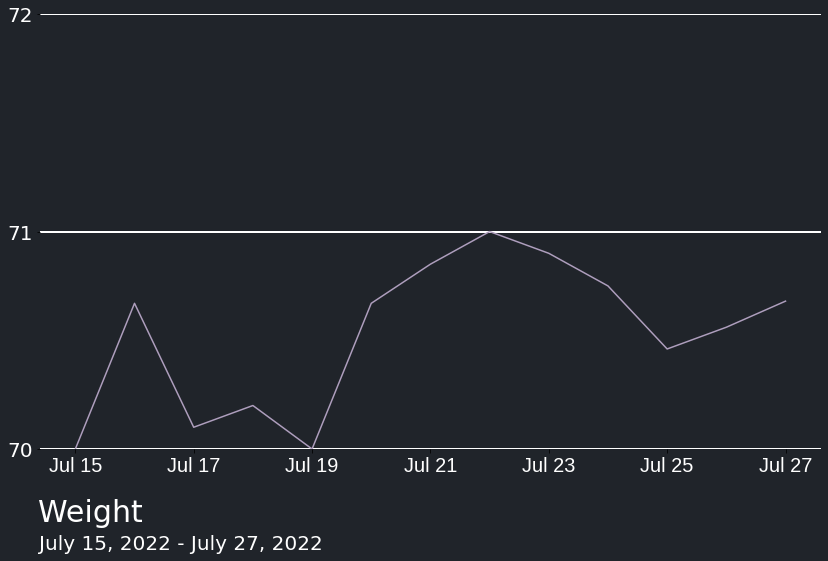

In [ ]:
# Initializing the figure
fig1 = plt.figure(figsize=(14,8),facecolor='#20242A')
ax = fig1.gca()
ax.set_facecolor('#20242A')

# Plotting the Data
plt.plot(weights.get('Day'),weights.get('Amount'),color='#AE9EBD')

# Adding grids
plt.grid(axis="y",lw=2,color='white')
plt.grid(axis='x', alpha=0)

# Setting x and y ticks
plt.yticks(range(int(np.floor(np.min(list(weights.get('Amount'))))),
         int(np.ceil(np.max(list(weights.get('Amount')))+2))),color='white',
         fontsize = 20)
plt.xticks(dates[::2],xticks_fixed[::2],color='white', fontsize = 20, 
           fontname='Liberation Sans')

# Setting y limits for the graph
plt.ylim(np.floor(np.min(list(weights.get('Amount')))),
         np.ceil(np.max(list(weights.get('Amount')))+1))


# Removing the spines on top, left and right
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Adding the weight footer
plt.text(0.175,0,'Weight',transform=fig1.transFigure, color='white',
         horizontalalignment='center', weight='light',fontsize=30, fontweight='normal',
         family='sans-serif')
plt.text(0.265,-0.05, start_date_string+" - "+end_date_string, 
         transform=fig1.transFigure, color='white',horizontalalignment='center',
         weight='light',fontsize=20, fontweight=550, family='sans-serif')
# Displaying the graph
plt.show()

*^ Above is a plot we created ourselves!*

## 4.2 Plotting participants Workout Minutes

If the participant wears an Apple Watch or uses another compatible device, they can go onto the Fitness App to find their average workout minutes in a chart like the one below.

<img src="https://i.imgur.com/fmwCGoj.jpg">

As cronometer automatically syncs with Apple Health, we have access to all this workout data. In this part of the notebook we will be recreating the plot above.

First, let's do a simple query to see what sorts of unique Exercise types exist in the Exercise DataFrame 

In [ ]:
np.unique(exercises.get('Exercise'))

array(['Active Energy Balance (Apple Health)',
       'High Intensity Interval Training (Apple Health)',
       'Running (Apple Health)',
       'Traditional Strength Training (Apple Health)'], dtype=object)

For Apple, it accounts for any exercise outside of the Active Energy Balance (Apple Health) as a workout which counts for these workout minutes. In the next line we will drop all the Active Energy Balance entries and group by specific dates for our chart. We will also plot the grouped dataframe to visualize the participants data.

In [ ]:
exercises_grouped = exercises[exercises.get('Exercise')!="Active Energy Balance (Apple Health)"].groupby('Day').sum()
exercises_grouped.head()

,Minutes,Calories Burned
Day,,
2022-06-09,67.501792,-576.56
2022-06-17,33.177951,-197.51
2022-06-18,43.729153,-393.29
2022-06-19,9.966750,-80.82
2022-06-22,26.483744,-161.77


In the lines below, add the start and end date for the chart below.

In [ ]:
#@title Set date range for the chart above

start_date = "2022-06-28" #@param {type:"date"}
end_date = "2022-07-27" #@param {type:"date"}

# The next line creates the date header for the chart
date_range_text= (str(datetime.strptime(start_date,'%Y-%m-%d').day)+
                  ' '+datetime.strptime(start_date,'%Y-%m-%d').strftime("%B")+
                  ' - '+str(datetime.strptime(end_date,'%Y-%m-%d').day)+' '+
                  datetime.strptime(end_date,'%Y-%m-%d').strftime("%B"))

Next, let's shorted our dataset to contain only the dates that we want for our chart. We will also plot the final DataFrame for reference.

In [ ]:
exercises_grouped = exercises_grouped[exercises_grouped.index >= start_date]
exercises_grouped = exercises_grouped[exercises_grouped.index <= end_date]
exercises_grouped.head()

,Minutes,Calories Burned
Day,,
2022-06-28,40.156748,-342.58
2022-06-30,59.360927,-564.91
2022-07-01,30.415496,-170.86
2022-07-02,29.625252,-161.63
2022-07-04,68.981474,-667.80


Before getting to the actual plot, first let's download the required fonts. Apple Health uses their own font called SF Pro, as it is not a free font, we will be using Open Sans which is very similar. The next lines will download this font.

In [ ]:
!wget https://www.fontsquirrel.com/fonts/download/open-sans
!unzip open-sans
!mv OpenSans-Regular.ttf /usr/share/fonts/truetype/
!mv OpenSans-Light.ttf /usr/share/fonts/truetype/
!mv OpenSans-Semibold.ttf /usr/share/fonts/truetype/
!mv OpenSans-Bold.ttf /usr/share/fonts/truetype/
!mv OpenSans-ExtraBold.ttf /usr/share/fonts/truetype/

--2022-08-11 19:54:10--  https://www.fontsquirrel.com/fonts/download/open-sans
Resolving www.fontsquirrel.com (www.fontsquirrel.com)... 45.79.150.110, 2600:3c03::f03c:91ff:fe37:ba29
Connecting to www.fontsquirrel.com (www.fontsquirrel.com)|45.79.150.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1215743 (1.2M) [application/octet-stream]
Saving to: ‘open-sans.8’

open-sans.8         100%[===================>]   1.16M  --.-KB/s    in 0.1s    

2022-08-11 19:54:11 (9.76 MB/s) - ‘open-sans.8’ saved [1215743/1215743]

Archive:  open-sans
  inflating: OpenSans-Light.ttf      
replace OpenSans-LightItalic.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: OpenSans-Regular.ttf    
  inflating: OpenSans-Semibold.ttf   
  inflating: OpenSans-Bold.ttf       
  inflating: OpenSans-ExtraBold.ttf  


Now that we have all the required Data, let's create the plot!

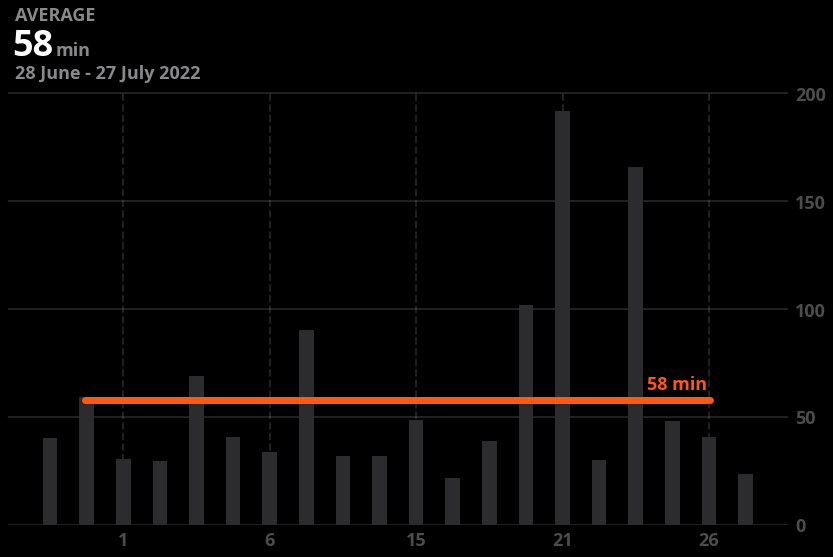

In [ ]:
# Initializing the figure
plt2 = plt.figure(figsize=(14,8),facecolor='#000000')
ax = plt2.gca()
ax.set_facecolor('#000000')
ax.yaxis.tick_right()
ax.set_axisbelow(True)

# Chart mean
chart_mean = int(exercises_grouped.get('Minutes').mean())

# Creating grid lines
plt.grid(axis = 'x',color="#a1a1a1", linestyle='--', linewidth=2, alpha = 0.2)
plt.grid(axis = 'y',color="#a1a1a1", linestyle='-', linewidth=2, alpha = 0.2)

# Plotting the chart
plt.bar(exercises_grouped.index,exercises_grouped.get('Minutes'),width=0.4, 
        color='#2C2C2E',joinstyle='round')

plt.axhline(y=int(exercises_grouped.get('Minutes').mean()), xmin=0.1, 
            linewidth=7,xmax= 0.9, color='#FF5810',solid_capstyle='round')

# Setting x and y ticks
yticks = [0,50,100,150,200]
plt.yticks(yticks, color='white',fontsize=16, fontweight=600,
           alpha=0.3, fontproperties=opensans_bold)
plt.xticks(exercises_grouped.index[2::4],
           [d.split('-')[2].strip('0') for d in list(exercises_grouped.index)][2::4],
           color='white',fontsize=16, fontweight=600,
           alpha=0.3, fontproperties=opensans_bold)
plt.text(0.79,chart_mean/yticks[-1]+0.07,str(chart_mean)+' min',
         fontsize=20,transform=plt2.transFigure, 
         horizontalalignment='center', color = '#FF5810', fontproperties=opensans_bold)

# Adding Heart header

openSansBold = '/usr/share/fonts/truetype/OpenSans-Bold.ttf'
opensans_bold = fm.FontProperties(fname=openSansBold, size= 18, weight='bold')
opensans_bold_heading = fm.FontProperties(fname=openSansBold, size= 36, weight='bold')


openSansExtraBold = '/usr/share/fonts/truetype/OpenSans-ExtraBold.ttf'
opensans_ebold = fm.FontProperties(fname=openSansExtraBold, size= 16, weight=500)

plt.text(0.173,1,"AVERAGE",fontsize=16,color='#89898B',transform=plt2.transFigure,
         horizontalalignment='center', fontproperties=opensans_bold)
plt.text(0.15,0.94,str(chart_mean),
         fontsize=28,transform=plt2.transFigure, 
         horizontalalignment='center', color = 'white',
         fontproperties=opensans_bold_heading)
plt.text(0.19,0.94,'min',fontsize=18,transform=plt2.transFigure, 
         horizontalalignment='center',color='#89898B',fontproperties=opensans_bold)
plt.text(0.225,0.9,date_range_text,fontsize=14,color='#89898B',
         transform=plt2.transFigure, horizontalalignment='center',
         fontproperties=opensans_bold)

# Plotting the chart
plt.show()

*^ Above is a plot we created ourselves!*

## 4.3 Calorie Consumption Breakdown

Cronometer App is particularly known for its meal tracking features. If a user went onto their Trends, they will be able to see a day-wise calorie breakdown like the one shown below.

<img src="https://i.imgur.com/Dl2V9wl.jpg" width='500px'>

This is a detailed breakdown which shows a user how many kilocalories they are consuming in Proteins, Carbohydrates, Fats and Alcohols. <br><br>

The Cronometer API also gave us access to the participants daily nutrition data. This would enable us to exactly re-create this chart using Python.

First, enter the start and end date for the chart.

In [ ]:
#@title Enter the Start Date

year_string = '2022' #@param {type:"string"}
month_string = '07' #@param {type:"string"}
day_string = '15' #@param{type:"string"}

start_date = year_string+'-'+month_string+'-'+day_string
print('Date is: '+start_date)


Date is: 2022-07-15


In [ ]:
#@title Enter the End Date

year_string = '2022' #@param {type:"string"}
month_string = '07' #@param {type:"string"}
day_string = '28' #@param{type:"string"}

end_date = year_string+'-'+month_string+'-'+day_string
print('Date is: '+end_date)


Date is: 2022-07-28


In the next line, we will fetch only the columns required for our plot and limit all the data between the Start and End date.

In [ ]:
test = nutrition[nutrition.get('Date')>=start_date].get(['Date','Carbs (g)','Fat (g)','Protein (g)','Alcohol (g)','Energy (kcal)'])
test = test[test.get('Date')<=end_date]
test.dropna().head()

,Date,Carbs (g),Fat (g),Protein (g),Alcohol (g),Energy (kcal)
40,2022-07-20,221.88,80.33,80.35,0.0,1883.14
41,2022-07-21,148.21,75.36,169.86,0.0,1970.47
42,2022-07-22,329.07,75.32,52.21,0.0,2251.68
43,2022-07-23,290.12,51.07,89.87,0.0,1937.83
44,2022-07-24,254.39,48.55,137.32,0.0,2096.45


In the above Data Frame we can notice that the Carbohydrates, Fats, Proteins and Alcohol values are in grams and not kcals (as required by the chart).<br><br>
Doing some quick research on USDA's website, we can find that [Carbohydrates provide 4 calories per gram, protein provides 4 calories per gram, fat provides 9 calories per gram](https://www.nal.usda.gov/legacy/fnic/how-many-calories-are-one-gram-fat-carbohydrate-or-protein#:~:text=Carbohydrates%20provide%204%20calories%20per,provides%209%20calories%20per%20gram), and alcohols provide 7 calories per gram. <br><br>

Thus, in the next lines, we will have to convert our values in grams to their corresponding calorie values.

In [ ]:
# Fixing the Date Values for the xticks in our chart
test = test.assign(Date_formatted = test.get('Date').apply(lambda x: 
                        date_fixer(x).split()[1]+' '+date_fixer(x).split()[0]))

# 1g Carbs is equal to 4 kcal
test = test.assign(Carbs = test.get('Carbs (g)')*4)

# 1g Proteins is equal to 4 kcal
test = test.assign(Protein = test.get('Protein (g)')*4)

# 1g Fats is equal to 9 kcal
test = test.assign(Fat = test.get('Fat (g)')*9)

# 1g Alcohol is equal to 7 kcal
test = test.assign(Alcohol = test.get('Alcohol (g)')*7)

# Replotting the dataframe for our reference
test.dropna().head()

,Date,Carbs (g),Fat (g),Protein (g),Alcohol (g),Energy (kcal),Date_formatted,Carbs,Protein,Fat,Alcohol
40,2022-07-20,221.88,80.33,80.35,0.0,1883.14,20 Jul,887.52,321.40,722.97,0.0
41,2022-07-21,148.21,75.36,169.86,0.0,1970.47,21 Jul,592.84,679.44,678.24,0.0
42,2022-07-22,329.07,75.32,52.21,0.0,2251.68,22 Jul,1316.28,208.84,677.88,0.0
43,2022-07-23,290.12,51.07,89.87,0.0,1937.83,23 Jul,1160.48,359.48,459.63,0.0
44,2022-07-24,254.39,48.55,137.32,0.0,2096.45,24 Jul,1017.56,549.28,436.95,0.0


Now that we have all the required data in our test dataframe, let's plot our chart!

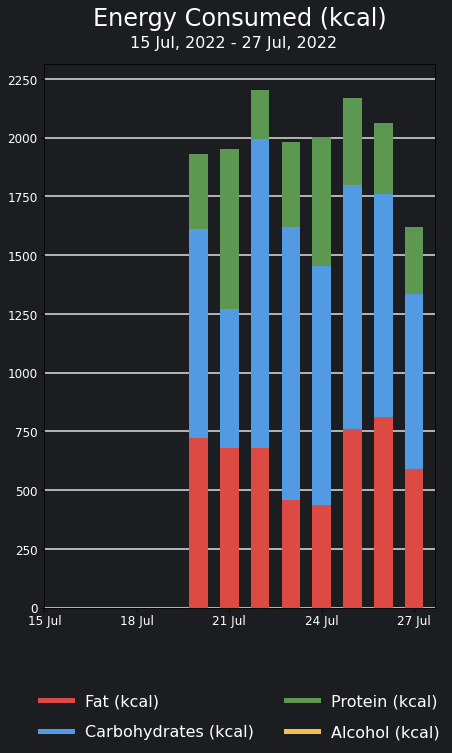

In [ ]:
# Creating a matplotlib plot of size 16,8 
fig3 = plt.figure(figsize=(7,10),facecolor='#1C1D21')
ax = fig3.gca()
ax.set_facecolor('#1C1D21')
ax.set_axisbelow(True)

# Adding header to the chart
header_text = (test.iloc[0].get('Date_formatted')+', '+
              test.iloc[-1].get('Date').split('-')[0]+' - '+
              test.iloc[-1].get('Date_formatted')+', '+
              test.iloc[0].get('Date').split('-')[0])
plt.title('Energy Consumed (kcal)',y=1.06, color='white',fontsize=24)
plt.suptitle(header_text,y=0.92, color='white',fontsize=16)

# Setting grid
plt.grid(axis='y', linewidth=2)

# Plotting the values for Fats
plt.bar(test.get('Date'),test.get('Fat'), color='#DB4B44', width=0.6)

# Plotting the values for Carbohydrates
plt.bar(test.dropna().get('Date'),test.dropna().get('Carbs'),color='#529BE3',
        width=0.6, bottom = list(test.dropna().get('Fat')))

# Plotting the values for Protein
plt.bar(test.dropna().get('Date'),test.dropna().get('Protein'),color='#5C9851',
        width=0.6, bottom = [l+w for l,w in zip(test.dropna().get('Fat'),
                                                test.dropna().get('Carbs'))])

# Plotting the values for Alcohol
plt.bar(test.dropna().get('Date'),test.dropna().get('Alcohol'),color='#F2C04F',
        width=0.6, bottom = [l+w+b for l,w,b in zip(test.dropna().get('Fat'),
                      test.dropna().get('Carbs'),test.dropna().get('Alcohol'))])


# Setting x and y ticks
plt.xticks(test.get('Date')[::3],list(test.get('Date_formatted'))[::3], 
           color='white', fontsize= 12)
plt.yticks([0,250,500,750,1000,1250,1500,1750,2000,2250],
           fontsize= 12, color='white')

#Plotting the legend
rect1 = mlines.Line2D([], [], marker=None, markersize=30, linewidth=5,
                      color="#DB4B44")
rect2 = mlines.Line2D([], [], marker=None, markersize=30, linewidth=5,
                      color="#529BE3")
rect3 = mlines.Line2D([], [], marker=None, markersize=30, linewidth=5,
                      color="#5C9851")
rect4 = mlines.Line2D([], [], marker='None', markersize=30, linewidth=5,
                      color="#F2C04F")
leg = ax.legend((rect1, rect2,rect3,rect4), ("Fat (kcal)", 
          "Carbohydrates (kcal)", "Protein (kcal)", "Alcohol (kcal)"),
          bbox_to_anchor=(0.5,-0.2), loc="center", frameon=False, ncol=2,
          markerscale=1.5, fontsize=16 , labelspacing=1)

# Setting color for all the labels to white
for text in leg.get_texts():
  text.set_color("white")


# Showing the chart
plt.show()

*^ Above is a plot that we have created ourselves*

# 5. Data Analysis

While doing some research for increasing muscle mass, I stumbled upon an [article](https://www.healthyeating.org/nutrition-topics/general/food-groups/protein) on this website called [HealthyEating](https://www.healthyeating.org) by the [Dairy Council of California](https://en.wikipedia.org/wiki/Dairy_Council_of_California). This article started with a claim that high-protein foods like meat, poultry, fish, beans and peas, eggs and nuts and seeds were also an excellent source of B vitamins. <br> <br>

##5.1 Analyzing correlation between Protein Content and Vitamin B content in food items!


In this portion of the notebook, we will see if there is a general correlation between a food's protein makeup and these given nutrients. <br><br>
Before beginning this experiment, let's replot our servings dataset which contains all the food items logged into the Cronometer app.

In [ ]:
servings.head()

,Day,Food Name,Amount,Energy (kcal),Alcohol (g),Caffeine (mg),Water (g),B1 (Thiamine) (mg),B2 (Riboflavin) (mg),B3 (Niacin) (mg),...,Leucine (g),Lysine (g),Methionine (g),Phenylalanine (g),Protein (g),Threonine (g),Tryptophan (g),Tyrosine (g),Valine (g),Category
0,2022-07-20,"Cheese Ravioli, with Tomato Sauce","1.00 cup, whole pieces",327.16,0.0,0.0,177.16,0.49,0.52,3.35,...,0.99,0.79,0.26,0.59,12.78,0.46,0.14,0.47,0.61,Cereal Grains and Pasta
1,2022-07-20,"Sausage, Pork, Fresh",3.00 medium link - breakfast size,195.00,0.0,0.0,29.93,0.15,0.11,3.67,...,0.82,0.74,0.26,0.40,11.12,0.37,0.11,0.31,0.53,Sausages and Luncheon Meats
2,2022-07-20,"Mango, Fresh",2.00 each,403.20,0.0,0.0,560.85,0.19,0.26,4.50,...,0.34,0.44,0.05,0.18,5.51,0.21,0.09,0.11,0.28,Fruits and Fruit Juices
3,2022-07-20,"Chocolate Milk, Whole",1.00 cup,207.50,0.0,2.5,205.75,0.09,0.41,0.31,...,0.75,0.66,0.21,0.41,7.93,0.34,0.10,0.40,0.52,Dairy and Egg Products
4,2022-07-20,"Beef Enchiladas, with Cheese","1.00 each - 6"" long, 6"" diameter tortilla rolled",219.88,0.0,0.0,119.90,0.08,0.18,2.41,...,1.16,1.03,0.34,0.59,13.63,0.51,0.10,0.49,0.72,"Meals, Entrees, and Sidedishes"


This current Data Frame has 55 columns, let's shorted it down to the columns that we specifically require in our analysis.

In [ ]:
servings_cleaned = servings.get(['Day','Protein (g)','B1 (Thiamine) (mg)',
       'B2 (Riboflavin) (mg)', 'B3 (Niacin) (mg)',
       'B5 (Pantothenic Acid) (mg)', 'B6 (Pyridoxine) (mg)',
       'B12 (Cobalamin) (µg)']).dropna()

servings_cleaned.head()

,Day,Protein (g),B1 (Thiamine) (mg),B2 (Riboflavin) (mg),B3 (Niacin) (mg),B5 (Pantothenic Acid) (mg),B6 (Pyridoxine) (mg),B12 (Cobalamin) (µg)
0,2022-07-20,12.78,0.49,0.52,3.35,0.88,0.21,0.74
1,2022-07-20,11.12,0.15,0.11,3.67,0.48,0.12,0.59
2,2022-07-20,5.51,0.19,0.26,4.50,1.32,0.80,0.00
3,2022-07-20,7.93,0.09,0.41,0.31,0.74,0.10,0.83
4,2022-07-20,13.63,0.08,0.18,2.41,0.39,0.25,0.99


As we there are multiple versions of Vitamin Bs, let's aggregate them into a single column with the sum of all Vitamin Bs.

In [ ]:
servings_cleaned = servings_cleaned.assign(Vitamin_B = servings_cleaned.get([
    'B1 (Thiamine) (mg)','B2 (Riboflavin) (mg)', 'B3 (Niacin) (mg)',
    'B5 (Pantothenic Acid) (mg)', 'B6 (Pyridoxine) (mg)',
    'B12 (Cobalamin) (µg)']).sum(axis=1))

servings_cleaned.head()

,Day,Protein (g),B1 (Thiamine) (mg),B2 (Riboflavin) (mg),B3 (Niacin) (mg),B5 (Pantothenic Acid) (mg),B6 (Pyridoxine) (mg),B12 (Cobalamin) (µg),Vitamin_B
0,2022-07-20,12.78,0.49,0.52,3.35,0.88,0.21,0.74,6.19
1,2022-07-20,11.12,0.15,0.11,3.67,0.48,0.12,0.59,5.12
2,2022-07-20,5.51,0.19,0.26,4.50,1.32,0.80,0.00,7.07
3,2022-07-20,7.93,0.09,0.41,0.31,0.74,0.10,0.83,2.48
4,2022-07-20,13.63,0.08,0.18,2.41,0.39,0.25,0.99,4.30


For our plot, let's see if there is a visual correlation between the Protein content of a food item and their Vitamin B content. 

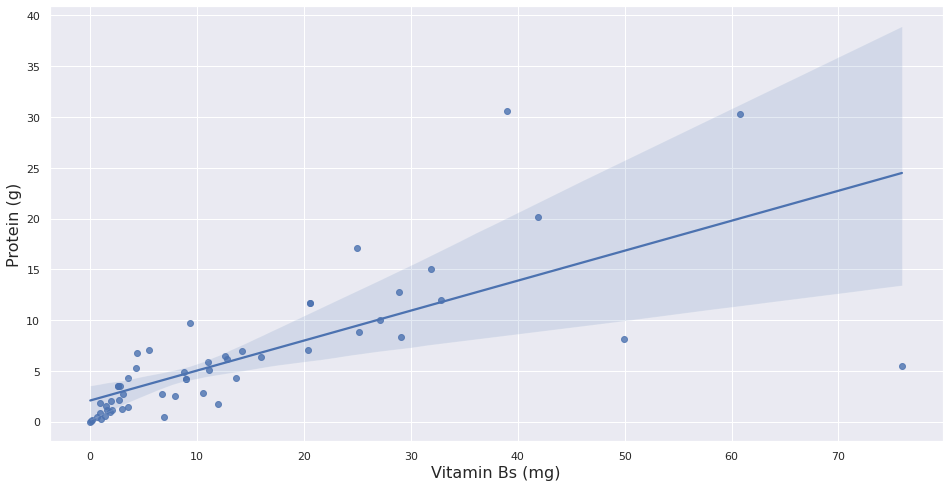

In [ ]:
# Setting Figure Size in Seaborn
sns.set(rc={'figure.figsize':(16,8)})

# Setting Seaborn plot style
sns.set_style("darkgrid")

#Plotting our data
plot = sns.regplot(data=servings_cleaned, x='Protein (g)', y="Vitamin_B")

#Renaming x and y labels
plot.set_ylabel("Protein (g)", fontsize = 16)
plot.set_xlabel("Vitamin Bs (mg)", fontsize = 16)

print()

Looking at the graph, it is visaully evident that with food that has high Protein content also has a high Vitamin B content. In the next line, we will prove this statistically.

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    servings_cleaned.get('Protein (g)'), servings_cleaned.get('Vitamin_B'))

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: 0.295
Coefficient of determination: 0.524
p-value: 4.26e-10


The p-value is 4.26e-10 which is much smaller than the 5% cutoff. This means that there is enough evidence to convincingly conclude that that there is a correlation between protein and vitamin B intake in a food item.

## 5.2 Outlier Detection

However, even though our P value seems to provide enough statistical significance that there is a correlation between Protein and Vitamin B makeup, there might be outliers that are not following this correlation. In this section of our analysis, we will find if there are outliers like that and if they exist, we will visually highlight them in our plot.

Before finding the individual outlier values, it would be interesting to see the summary of our Protein and Vitamin B intake. It will give us a clear idea of what values are typical and which values can be considered atypical based on the data that we recieved from Cronometer.

In [ ]:
servings_cleaned_summary = servings_cleaned.describe().get(
                                          ['Protein (g)','Vitamin_B'])
servings_cleaned_summary

,Protein (g),Vitamin_B
count,55.000000,55.000000
mean,13.685091,6.110727
std,16.144212,6.583583
min,0.010000,0.000000
25%,2.570000,1.620000
50%,8.760000,4.260000
75%,20.485000,7.585000
max,75.940000,30.640000


To locate the outliers we will be using a supervised as well as unsupervised algorithm called the Elliptic Envelope. In statistical studies, Elliptic Envelope created an imaginary elliptical area around a given dataset where values inside that imaginary area is considered to be normal data, and anything else is assumed to be outliers. It assumes that the given Data follows a gaussian distribution.

"The main idea is to define the shape of the data and anomalies are those observations that lie far outside the shape. First a robust estimate of covariance of data is fitted into an ellipse around the central mode. Then, the Mahalanobis distance that is obtained from this estimate is used to define the threshold for determining outliers or anomalies." [(S. Shriram and E. Sivasankar ,2019, pp. 221-225)](https://ieeexplore.ieee.org/document/9004325)

In [ ]:
# Sometimes EllipticEnvelope shows slicing based copy warnings
# The next line changes a setting that prevents the error from happening

pd.set_option('mode.chained_assignment', None)

#create the model, set the contamination as 0.02
EE_model = EllipticEnvelope(contamination = 0.02)

#implement the model on the data
outliers = EE_model.fit_predict(servings_cleaned.get(
                                                  ['Protein (g)','Vitamin_B']))

#extract the labels
servings_cleaned["outlier"] = copy.deepcopy(outliers)

#change the labels
# We use -1 to mark an outlier and +1 for an inliner
servings_cleaned["outlier"] = servings_cleaned["outlier"].apply(
                                    lambda x: str(-1) if x == -1 else str(1))

#extract the score
servings_cleaned["EE_scores"] = EE_model.score_samples(
                      servings_cleaned.get(['Protein (g)','Vitamin_B']))

#print the value counts for inlier and outliers
print(servings_cleaned["outlier"].value_counts())

1     53
-1     2
Name: outlier, dtype: int64


Below we will replot the servings_cleaned_summary dataframe to see how the two new columns were applied to it!

In [ ]:
servings_cleaned

,Day,Protein (g),B1 (Thiamine) (mg),B2 (Riboflavin) (mg),B3 (Niacin) (mg),B5 (Pantothenic Acid) (mg),B6 (Pyridoxine) (mg),B12 (Cobalamin) (µg),Vitamin_B,outlier,EE_scores
0,2022-07-20,12.78,0.49,0.52,3.35,0.88,0.21,0.74,6.19,1,-0.707307
1,2022-07-20,11.12,0.15,0.11,3.67,0.48,0.12,0.59,5.12,1,-0.393624
2,2022-07-20,5.51,0.19,0.26,4.50,1.32,0.80,0.00,7.07,1,-7.854707
3,2022-07-20,7.93,0.09,0.41,0.31,0.74,0.10,0.83,2.48,1,-1.258945
4,2022-07-20,13.63,0.08,0.18,2.41,0.39,0.25,0.99,4.30,1,-3.166149
5,2022-07-20,20.38,0.12,0.86,0.14,2.26,0.60,3.07,7.05,1,-6.142756
6,2022-07-20,8.96,0.28,0.12,3.20,0.47,0.15,0.00,4.22,1,-0.118128
7,2022-07-20,0.04,0.00,0.00,0.00,0.01,0.00,0.01,0.02,1,-1.335237
8,2022-07-21,1.03,0.01,0.01,0.18,0.04,0.01,0.00,0.25,1,-1.215270
9,2022-07-21,41.92,0.22,0.24,17.15,1.34,0.79,0.44,20.18,1,-27.807099



Now that we have labeled the outliers as -1, let's try to see which values of average heart rate and steps are being identified as outliers by our Elliptic Envelope Algorithm.

In [ ]:
outlier_df = servings_cleaned[servings_cleaned.get('outlier')=='-1'].get(
    ['Protein (g)','Vitamin_B'])
outlier_df

,Protein (g),Vitamin_B
14,75.94,5.5
39,49.93,8.1


Sweet, now that we know that there were outliers in our dataset, let's try to visually see which pair of values are being identified as outliers using a plot. Highlighting these outliers in a bright red color will make it super easy for us to identify them in our plot.

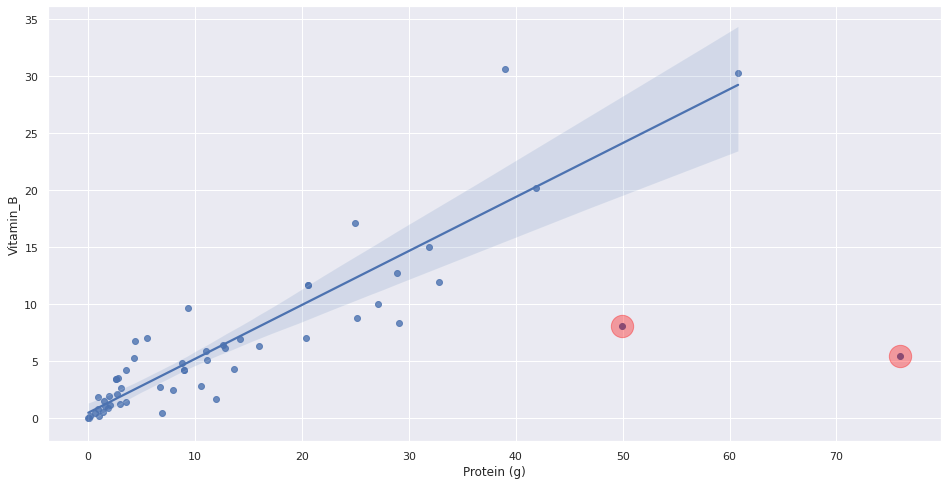

In [ ]:
# Setting Figure Size in Seaborn
sns.set(rc={'figure.figsize':(16,8)})

# Setting Seaborn plot style
sns.set_style("darkgrid")

#Plotting our data
plot = sns.regplot(x='Protein (g)', y='Vitamin_B', data=servings_cleaned.drop(
    outlier_df.index))

plt.scatter(outlier_df.get('Protein (g)'),outlier_df.get('Vitamin_B'))
plt.scatter(outlier_df.get('Protein (g)'),outlier_df.get('Vitamin_B'),
            facecolors='red',alpha=.35, s=500)

plt.show()

Thus, the points highlighted in red are ones that seem to not be following the general trend of our dataset. Lastly, let's see what the new p-value is after outlier removal!

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    servings_cleaned.drop(outlier_df.index).get('Protein (g)'),
     servings_cleaned.drop(outlier_df.index).get('Vitamin_B'))

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: 0.473
Coefficient of determination: 0.834
p-value: 1.56e-21


Our new p-value after removing any outliers is 1.56e-21 which is very less than 5% and smaller than our p-value with the outliers included in the dataset. Therefore, after removing the outliers, our result is statistically significant which means that there is enough evidence to conclude that that there is a correlation between Protein content and Vitamin B content in a food item.